# Product Recommender System Using OpenAI API

Author: Stefanie Warum

In [1]:
import os
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import distance

# Define the model to use
model = "gpt-3.5-turbo"
client = OpenAI(api_key=os.environ["OPENAI"])

In [2]:
# Import file with products
from products import products
from last_product import last_product
from user_history import user_history

In [3]:
for product in products[:5]:
    print(f"{product['title']}: {product['price']}")

Ski Pass Alpine Valley: 65.0
Beginner Ski Lessons: 120.0
High-Performance Ski Set Rental: 35.0
Snow Festival Ticket: 45.0
Mountain Top Dining Experience: 150.0


## Create embeddings for product descriptions

In [4]:
# Extract a list of product short descriptions from products
product_descriptions = [product["short_description"] for product in products]

# Create embeddings for each product description
response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=product_descriptions
)

response_dict = response.model_dump()

# Extract the embeddings from response_dict and store in products
for i, product in enumerate(products):
    product['embedding'] = response_dict["data"][i]["embedding"]
    
print(products[0].items())

dict_items([('title', 'Ski Pass Alpine Valley'), ('short_description', 'Full-day lift pass for Alpine Valley Resort, granting access to all slopes.'), ('price', 65.0), ('category', 'Ski Pass'), ('features', ['Unlimited lifts', 'Access from 9 AM to 5 PM', 'Includes night skiing on select days']), ('embedding', [0.001773689640685916, 0.014779654331505299, 0.02460215613245964, -0.037270430475473404, -0.026556165888905525, 0.020654795691370964, -0.022333407774567604, -0.034201718866825104, -0.002244160044938326, -0.022962886840105057, 0.003967032302170992, 0.008845498785376549, 0.001619598246179521, -0.029139654710888863, -0.01018969900906086, -0.01736314222216606, 0.010615909472107887, -0.026936477050185204, 0.006648877169936895, 0.008379945531487465, 0.011074905283749104, -0.006202995777130127, 0.0005975137464702129, -0.010596238076686859, -0.010386412031948566, 0.017664767801761627, 0.005032557528465986, -0.004927644040435553, 0.020392512902617455, -0.0210744496434927, 0.035172168165445

## Visualizing the embedded descriptions

Use t-SNE for dimensionality reduction and reducing the embeddings data from 1536 to e.g. 2, which will make the data more easily to visualize.

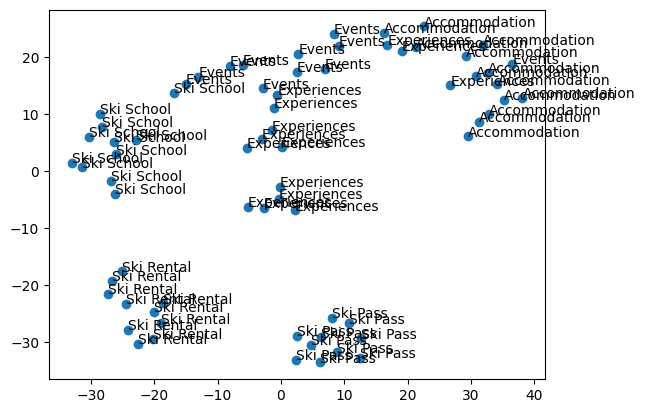

In [5]:
# Create reviews and embeddings lists using list comprehensions
categories = [product['category'] for product in products]
embeddings = [product['embedding'] for product in products]

# Reduce the number of embeddings dimensions to two using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Create a scatter plot from embeddings_2d
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, category in enumerate(categories):
    plt.annotate(category, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

## Custom function for embeddings
create_embeddings() function that sends an input, texts, to the embedding model, and returns a list containing the embeddings for each input text.

In [6]:
def find_n_closest(query_vector, embeddings, n=3):
  distances = []
  for index, embedding in enumerate(embeddings):
    # Calculate the cosine distance between the query vector and embedding
    dist = distance.cosine(query_vector, embedding)
    # Append the distance and index to distances
    distances.append({"distance": dist, "index": index})
  # Sort distances by the distance key
  distances_sorted = sorted(distances, key=lambda x: x["distance"])
  # Return the first n elements in distances_sorted
  return distances_sorted[0:n]

In [7]:
# Define a create_embeddings function
def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
  )
  response_dict = response.model_dump()
  
  return [data['embedding'] for data in response_dict['data']]

In [8]:
# Embed the search text
search_text = "skirental"
search_embedding = create_embeddings(search_text)[0]

distances = []
for product in products:
  # Compute the cosine distance for each product description
  dist = distance.cosine(search_embedding, product["embedding"])
  distances.append(dist)

# Find and print the most similar product short_description    
min_dist_ind = np.argmin(distances) #finds the minimum cosine distance from distances-list
print(products[min_dist_ind]["short_description"])

Special ski pass for young skiers under 18, with access to beginner and intermediate slopes.


In [15]:
# Restructure features in a string
def create_product_text(product):
    if 'features' in product and isinstance(product['features'], list):
        return ', '.join(product['features'])
    else:
        return "No features available."

In [13]:
# Before this line, add the diagnostic code to print out each product's type and content
for product in user_history:
    print(f"Type: {type(product)}, Content: {product}")

# Existing line causing the error:
history_texts = [create_product_text(product) for product in user_history]
history_embeddings = create_embeddings(history_texts)
mean_history_embeddings = np.mean(history_embeddings, axis=0)

# Continue with your existing code

Type: <class 'dict'>, Content: {'title': 'Mountain Top Dining Experience', 'short_description': 'A luxurious dining experience at the summit with stunning panoramic views.', 'price': 150.0, 'category': 'Experiences', 'features': ['Gourmet 5-course meal', 'Includes a complimentary glass of champagne', 'Transport via chairlift']}
Type: <class 'dict'>, Content: {'title': 'Luxury Ski-in/Ski-out Condo', 'short_description': 'Enjoy the ultimate convenience with our luxury condo located right on the slope.', 'price': 350.0, 'category': 'Accommodation', 'features': ['2-bedroom luxury condo', 'Ski-in/ski-out access', 'Private balcony with hot tub']}
Type: <class 'dict'>, Content: {'title': 'Snowboard Fun Lessons', 'short_description': 'Interactive group lessons for snowboarding enthusiasts looking to improve their skills.', 'price': 135.0, 'category': 'Ski School', 'features': ['3-hour sessions for all ages', 'Focus on fun and safety', 'All gear provided']}
Type: <class 'dict'>, Content: {'titl

In [10]:
# Combine the features for last_product and each product in products
last_product_text = create_product_text(last_product)
product_texts = [create_product_text(product) for product in products]

# Embed last_product_text and product_texts
last_product_embeddings = create_embeddings(last_product_text)[0]
product_embeddings = create_embeddings(product_texts)

# Find the three smallest cosine distances and their indexes
hits = find_n_closest(last_product_embeddings, product_embeddings)

for hit in hits:
  product = products[hit['index']]
  print(product['title'])

Full Season Ski Pass
Ultimate Snow Experience Pass
Ski Pass Alpine Valley


In [11]:
# Prepare and embed the user_history, and calculate the mean embeddings
history_texts = [create_product_text(product) for product in user_history]
history_embeddings = create_embeddings(history_texts)
mean_history_embeddings = np.mean(history_embeddings, axis=0)

# Filter products to remove any in user_history
products_filtered = [product for product in products if product not in user_history]

# Combine product features and embed the resulting texts
product_texts = [create_product_text(product) for product in products_filtered]
product_embeddings = create_embeddings(product_texts)

hits = find_n_closest(mean_history_embeddings, product_embeddings)

for hit in hits:
  product = products_filtered[hit['index']]
  print(product['title'])

Mountain Top Dining Experience
Eco-Friendly Ski Lodge
Night Skiing Excursion
